## Importing the data

The Overture website recommends various workflows to download the data. Among them, the one allowing to work a local and self-sufficient manner is the python based [`overturemaps`](https://github.com/OvertureMaps/overturemaps-py) CLI, available from pip. It requires few arguments: 4 numeric values for the bbox, the type of layer to extract and the type of file to write into. 


In [1]:
#| echo: true
#| eval: false

!overturemaps download --bbox=west,south,east,north -f geoparquet --type=segment -o tanzania_roads.geoparquet

More information on the values allowed in `--type` is available via the shell command `overturemaps download --help`.
More methods to download Overture data are shown in the [documentation](https://docs.overturemaps.org/getting-data/). 

## Working with the data

Once the data is stored locally as `.geoparquet`, we can work with it in python with `duckdb`. 


In [2]:
#| echo: false

import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
import duckdb as db

roads = db.read_parquet("../tanzania_roads.geoparquet")

The data set is read as traditional parquet in which the geometry column is a `blob`. 


In [4]:
#| echo: false
#| 
db.sql("SELECT id,class,geometry FROM roads LIMIT 10;")

┌──────────────────────┬──────────────┬────────────────────────────────────────────────────────────────────────────────┐
│          id          │    class     │                                    geometry                                    │
│       varchar        │   varchar    │                                      blob                                      │
├──────────────────────┼──────────────┼────────────────────────────────────────────────────────────────────────────────┤
│ 089962508d97ffff04…  │ path         │ \x00\x00\x00\x00\x02\x00\x00\x00\x02@<\xD1\xA5\x99\x82\x1C\xA5\xC01.1\x0D\xB…  │
│ 089962508d97ffff04…  │ path         │ \x00\x00\x00\x00\x02\x00\x00\x00\x08@<\xD1\xD2\x08u\xF0G\xC01.\x0A+\xD2\xEC\…  │
│ 088962508d9fffff04…  │ path         │ \x00\x00\x00\x00\x02\x00\x00\x00\x13@<\xD1\xA5\x99\x82\x1C\xA5\xC01.1\x0D\xB…  │
│ 089962508d83ffff04…  │ path         │ \x00\x00\x00\x00\x02\x00\x00\x00\x0B@<\xD2\x06\xEF\x07\x8A8\xC01-\xE34\x17^\…  │
│ 08496251ffffffff04…  │ seconda

The `duckdb` loaders do not support reading *geoparquet* at the moment, but this feature is expected in the upcoming version. We stick to this format for its efficiency when storing large extracts.

To further work with the geometry, we install the `duckdb` extension. 


In [5]:
# installing and loading the extension.
db.install_extension("spatial")
db.load_extension("spatial")

This will allow us to work with the geometry column from within the database, bypassing the limitation of the parquet reader.

## Basic interaction with the data

Still with the `duckdb` package and its SQL-like syntax.

#### Counting values


In [6]:
db.sql("SELECT count(*) as N_segments,class FROM roads GROUP BY class;")

┌────────────┬───────────────┐
│ N_segments │     class     │
│   int64    │    varchar    │
├────────────┼───────────────┤
│    1249548 │ path          │
│        263 │ crosswalk     │
│        144 │ cycleway      │
│       1481 │ parking_aisle │
│      57044 │ footway       │
│      44763 │ trunk         │
│        457 │ pedestrian    │
│      27548 │ primary       │
│         93 │ NULL          │
│        373 │ steps         │
│         63 │ motorway      │
│      83290 │ unknown       │
│       3974 │ driveway      │
│     502882 │ track         │
│      69192 │ secondary     │
│    1792660 │ residential   │
│         29 │ bridleway     │
│        459 │ alley         │
│     148719 │ tertiary      │
│    1128458 │ unclassified  │
│        319 │ sidewalk      │
│       2473 │ living_street │
├────────────┴───────────────┤
│ 22 rows          2 columns │
└────────────────────────────┘

## Data Manipulation

The advantage of working with `duckdb` is that intensive computations are performed outside the python environment, and all we need to do is *collect* the results.

### Etracting a subset


In [7]:
# filtering out cycleways
ways = db.sql("Select id,ST_GeomFromWKB(geometry) as geometry,subtype,class from roads where class='primary';")

# intermediate step: transform the geometry into WKT and read the subset of data as a pandas DataFrame
ways_wkt = db.sql("select id, ST_AsText(geometry) as geometry, subtype, class from ways;").df()

# Finally, convert the geometry and create a geopandas GeoDataFrame. 
ways_df = gpd.GeoDataFrame(ways_wkt
                          ,geometry=gpd.GeoSeries.from_wkt(ways_wkt["geometry"])
                          ,crs=4326
                          )
ways_df.head()

,id,geometry,subtype,class
0,088971928a1fffff047fb94fc9b6da63,"LINESTRING (30.87546 -17.07291, 30.87616 -17.0...",road,primary
1,08497193ffffffff047fafebb6014c10,"LINESTRING (30.86457 -17.04400, 30.86431 -17.0...",road,primary
2,08896269203fffff047daff58b6ae4c4,"LINESTRING (30.84229 -17.03138, 30.84201 -17.0...",road,primary
3,089962692037ffff047fee1fd2e8c575,"LINESTRING (30.84418 -17.03071, 30.84229 -17.0...",road,primary
4,08a962692022ffff047ffd55846af8dc,"LINESTRING (30.84504 -17.03038, 30.84418 -17.0...",road,primary


The resulting types:


In [8]:
#| echo: false
#| fig-align: center

ways_df.dtypes

id            object
geometry    geometry
subtype       object
class         object
dtype: object

## Plotting


<Axes: >

Text(0.5, 1.0, 'Example segment class')

Text(0.5, 25.13333333333333, 'Longitude [deg]')

Text(303.74186744197146, 0.5, 'Latitude [deg]')

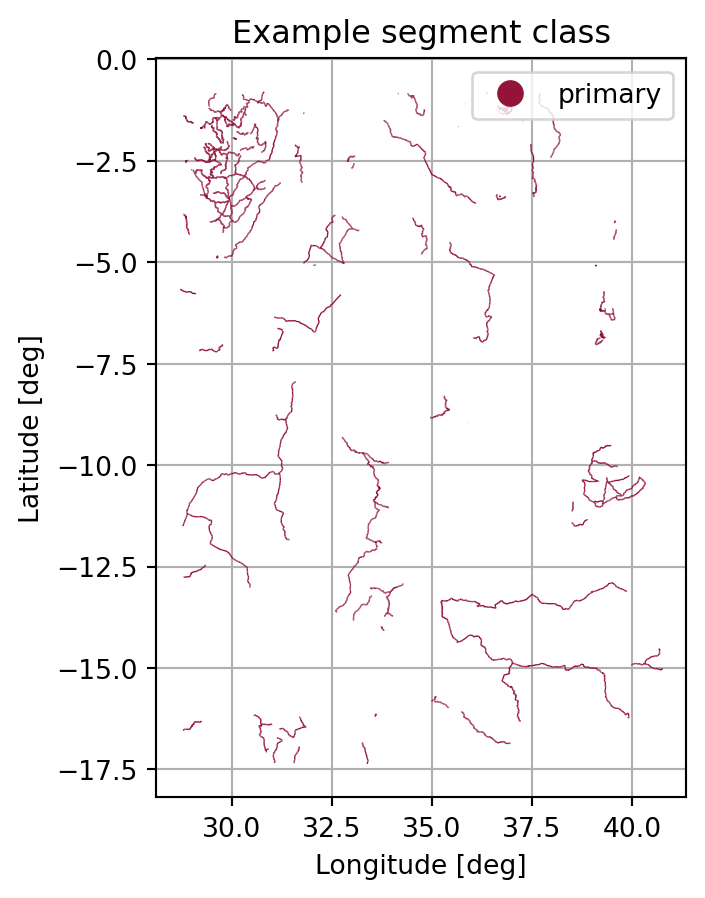

In [9]:
#| echo: false
#| eval: true
#| output: true
#| fig-align: center
# label: fig-polar
# fig-cap: "Cycleways of Tanzania"


f, ax = plt.subplots()

cmap = ListedColormap(
    [
        "#941339",  # motorway
        # "#982261",  # primary
        # "#020202",  # rail
        "#8748bc",  # secondary
        # "#48bc7b",  # tertiary
        # "#cb3e4e",  # trunk
    ]
)

ways_df.plot(
    ax=ax,
    column="class",
    legend=True,
    alpha=1,
    linewidth=0.5,
    categorical=True,
    cmap=cmap,
)

ax.grid()
ax.set_title("Example segment class")
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")

plt.show()

## Other workflows 
### GeoPandas
Once the data is extracted, other options are available to work with it.
`GeoPandas` converts the geometry column for us, so no extra steps are required.

In [10]:
#| echo: true
#| eval: false
#| 
ways_gpd = gpd.read_parquet("../tanzania_roads.geoparquet"
                        #  ,columns=["id","class","connector_ids","geometry"] # read in desired columns only.
                         )


It is however less efficient to read with this method, so it's only recommended for relatively small data sets. 

### pyArrow 

Is the under the hood reader of `geopandas`.

In [11]:
#| echo: true
#| eval: false
#| 
import pyarrow.parquet as pq

ways_arrow = pq.read_table("../tanzania_roads.geoparquet")

### Still more tools

The vast python package ecosystem provides a wide range of tools that work with (geo)parquet and (geo)arrow file formats and specifications, among them: 

- [geoarrow](https://github.com/geoarrow/geoarrow-python): the low level specification of parquet.
- [geoparquet](https://github.com/darcy-r/geoparquet-python)
